In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import f1_score
import warnings

warnings.simplefilter('ignore')

In [50]:
df = sns.load_dataset('penguins')
df = df.dropna(ignore_index=True)

In [51]:
X = df.drop(['species'], axis=1)
y = df['species']
X['Male'] = X['sex'].replace('Female', 0).replace('Male', 1)
X.drop(['sex'], axis=1, inplace=True)
X = pd.get_dummies(X)
X = X.replace(True, 1).replace(False, 0)

Стоит иногда смотреть на отклонение метрик, вдруг модель рандомная

In [60]:
clfs = []
scores = []
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=7575)
for i, (train_ind, test_ind) in enumerate(kf.split(X, y)):
    X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
    y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]
    clf = RandomForestClassifier(
        n_estimators=100,
        min_samples_leaf=4,
        n_jobs=-1,
        max_features=0.60,
        # class_weight = 'balanced',
        random_state=7575,
        max_depth=6,
    )
    clf.fit(X_train, y_train)
    clfs.append(clf)
    score = f1_score(y_test, clf.predict(X_test), average='micro')
    scores.append(score)
    print(f'{i}: {score}')
print(
    "Средняя метрика --", np.mean(scores, dtype="float16"), "Отклонение метрик --", np.std(scores).round(4)
)

0: 0.9850746268656716
1: 0.9850746268656716
2: 1.0
3: 0.9545454545454546
4: 0.9848484848484849
Средняя метрика -- 0.982 Отклонение метрик -- 0.0149


 Какие валидации полезно попробовать? <br>
StratifiedGroupKFold - он же, но еще и стратифицированный (сбалансированный)<br>
RepeatedStratifiedKFold - а тут стратифицированный, но еще дополнительно с повторениями<br>
А где взять RepeatedStratifiedGroupKFold? :)<br>
Еще несколько<br>
Shuffle Split - сначала перемешивает все сэмплы, потом разделяет на заданное количество фолдов.<br>
Time Series Split - используется, когда данные упорядочены по времени.<br>
<br>
Leave One Out (LOO) - удаляет только 1 сэмпл данных из датасета для каждого фолда (создает все возможные наборы для обучения).<br>
Leave One Group Out - то же самое, но каждый раз удаляет 1 группу сэмплов.<br>
Leave P Out - удаляет P сэмплов из датасета и создает все возможные наборы, значения в наборах могут повторяться.<br>
🍕 Когда какую выбрать?<br>
Есть временная зависимость? ➡️ TimeSeriesSplit<br>
Мало данных и быстро учится? ➡️ LeaveOneOut<br>
Много данных, но быстро учится? ➡️ KFold<br>
Очень много данных и долго учится? ➡️ старый добрый train_test_split()<br>
Есть дисбаланс классов? ➡️ Любой итератор с приставкой Stratified<br>
Есть группы и нельзя допусть их одновременного присутствия в train и test? ➡️ Любой итератор с приставкой Group<br>

In [62]:
best_model = clfs[np.argmax(scores)]

In [89]:
def plot_imp(imp, tab):
    data = sorted([[imp[i], tab[i]] for i in range(len(imp))], key=lambda x: x[0], reverse=True)
    imp = [i[0] for i in data]
    tab = [i[1] for i in data]
    sns.barplot(x=imp, y=tab)

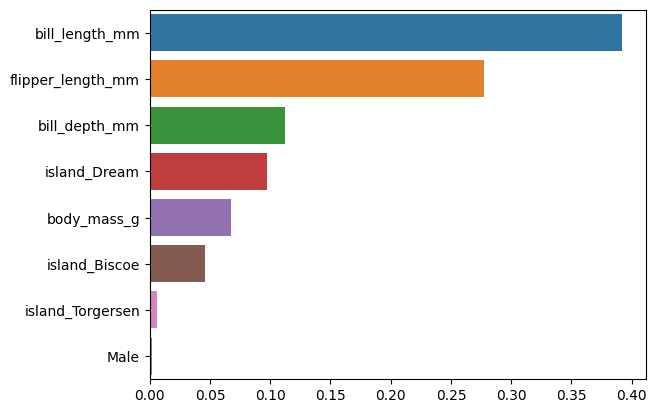

In [92]:
imp = best_model.feature_importances_
tab = X.columns
plot_imp(imp, tab)